#A temp-forecasting eg:- to data uploading from Amazon Web Services (AWS) /keras

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 21:30:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.40.248, 52.217.132.32, 52.216.245.254, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.40.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  48.9MB/s    in 0.3s    

2023-11-05 21:31:00 (48.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [4]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

#Inspect the data of the Jena Weather Dataset

In [7]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

numberof_variables = len(header)
print("Number_of_Variables:", numberof_variables)
numberof_rows = len(lines)
print("Number_of_Rows:", numberof_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number_of_Variables: 15
Number_of_Rows: 420451


#Parsing and Storing the Data

In [9]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

#to plot the temperature time-series

Text(0, 0.5, 'Temp')

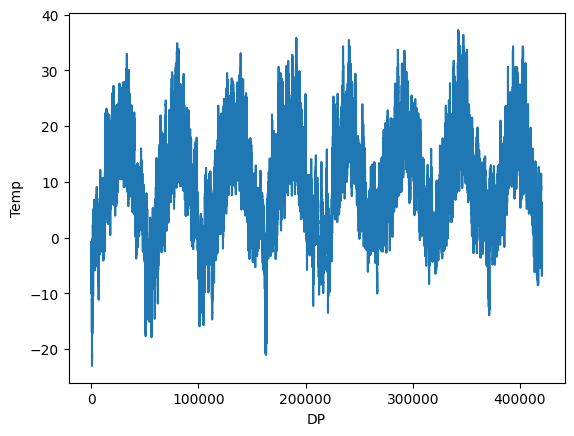

In [10]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('DP')
plt.ylabel('Temp')

#plot the first 10 days of temp time-series

Text(0, 0.5, 'Temp')

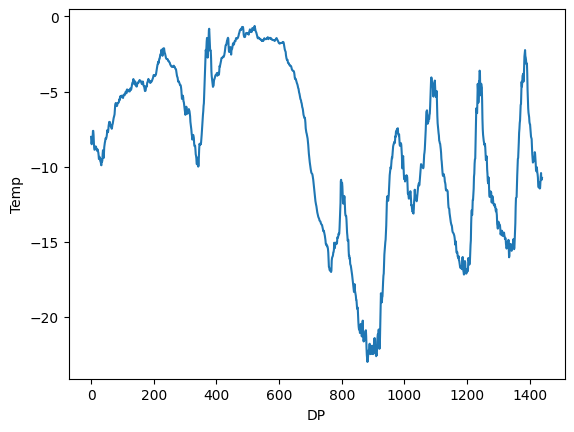

In [11]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('DP')
plt.ylabel('Temp')

#To compute the number of samples which we'll use for each data split

In [12]:
numberof_training_samples = int(0.5 * len(raw_data))
numberof_validation_samples = int(0.25 * len(raw_data))
numberof_testing_samples = len(raw_data) - numberof_training_samples - numberof_validation_samples
print("numberof_training_samples:", numberof_training_samples)
print("numberof_validation_samples:", numberof_validation_samples)
print("numberof_testing_samples:", numberof_testing_samples)

numberof_training_samples: 210225
numberof_validation_samples: 105112
numberof_testing_samples: 105114


#Preparing the Data

Normalizing the Data

In [13]:
mean = raw_data[:numberof_training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:numberof_training_samples].std(axis=0)
raw_data /= std

In [14]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


#To Instantiating datasets for training, validation, and testing sets

In [15]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1024

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=numberof_training_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=numberof_training_samples,
    end_index=numberof_training_samples + numberof_validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=numberof_training_samples + numberof_validation_samples)

#To inspect the output of one of our datasets

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1024, 120, 14)
targets shape: (1024,)


#A common-sense, non-machine-learning baseline

Computing the common-sense basline MAE by using the evaluate_naive_method.

In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


 a result of this simple baseline, the validation MAE is 2.44 deg Cel, and the test MAE is 2.62 deg cel.
Therefore, an average deviation of approximately two and a half degrees would result if the temperature in the future remains the same as the current temperature.

#Trying a basic ML model

training and evaluating a densely connected model

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 47s 222ms/step - loss: 18.6927 - mae: 3.3228 - val_loss: 18.2607 - val_mae: 3.4270
Epoch 2/10
205/205 [==============================] - 46s 218ms/step - loss: 11.4304 - mae: 2.6614 - val_loss: 13.8671 - val_mae: 2.9699
Epoch 3/10
205/205 [==============================] - 54s 259ms/step - loss: 10.3437 - mae: 2.5318 - val_loss: 10.7459 - val_mae: 2.5852
Epoch 4/10
205/205 [==============================] - 45s 215ms/step - loss: 9.7237 - mae: 2.4514 - val_loss: 10.8294 - val_mae: 2.5977
Epoch 5/10
205/205 [==============================] - 45s 217ms/step - loss: 9.2884 - mae: 2.3961 - val_loss: 12.0660 - val_mae: 2.7598
Epoch 6/10
205/205 [==============================] - 52s 247ms/step - loss: 9.0337 - mae: 2.3619 - val_loss: 10.5843 - val_mae: 2.5740
Epoch 7/10
205/205 [==============================] - 45s 215ms/step - loss: 8.7742 - mae: 2.3297 - val_loss: 10.2788 - val_mae: 2.5332
Epoch 8/10
205/205 [=========================

#To Plot the results

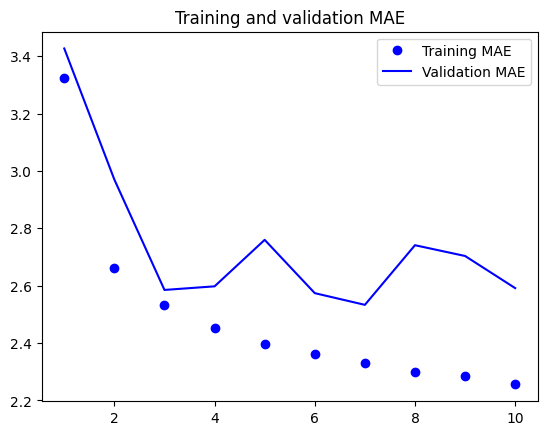

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Trying a 1D Convolutional model

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 58s 249ms/step - loss: 46.6447 - mae: 5.2001 - val_loss: 24.6105 - val_mae: 3.9523
Epoch 2/10
205/205 [==============================] - 53s 253ms/step - loss: 22.2474 - mae: 3.7538 - val_loss: 18.7776 - val_mae: 3.4042
Epoch 3/10
205/205 [==============================] - 55s 262ms/step - loss: 19.3654 - mae: 3.4962 - val_loss: 16.4387 - val_mae: 3.1878
Epoch 4/10
205/205 [==============================] - 46s 220ms/step - loss: 17.3623 - mae: 3.3120 - val_loss: 15.0624 - val_mae: 3.0637
Epoch 5/10
205/205 [==============================] - 48s 230ms/step - loss: 16.3335 - mae: 3.2095 - val_loss: 14.9796 - val_mae: 3.0513
Epoch 6/10
205/205 [==============================] - 52s 250ms/step - loss: 15.7251 - mae: 3.1488 - val_loss: 17.1020 - val_mae: 3.2922
Epoch 7/10
205/205 [==============================] - 54s 258ms/step - loss: 15.2788 - mae: 3.0990 - val_loss: 15.8442 - val_mae: 3.1662
Epoch 8/10
205/205 [=====================

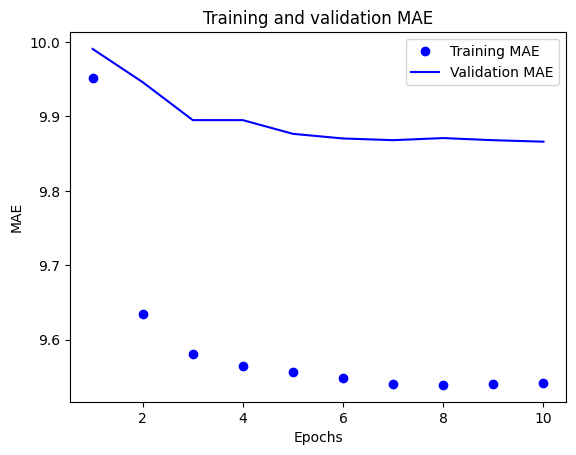

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#First recurrent baseline

A Simple LSTM model

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 52s 233ms/step - loss: 29.0026 - mae: 3.8934 - val_loss: 11.1892 - val_mae: 2.5903
Epoch 2/10
205/205 [==============================] - 52s 248ms/step - loss: 10.2399 - mae: 2.4995 - val_loss: 9.9665 - val_mae: 2.4568
Epoch 3/10
205/205 [==============================] - 53s 253ms/step - loss: 8.8343 - mae: 2.3194 - val_loss: 9.9453 - val_mae: 2.4528
Epoch 4/10
205/205 [==============================] - 53s 254ms/step - loss: 7.7248 - mae: 2.1656 - val_loss: 10.1932 - val_mae: 2.4939
Epoch 5/10
205/205 [==============================] - 46s 221ms/step - loss: 6.9057 - mae: 2.0447 - val_loss: 10.7975 - val_mae: 2.5632
Epoch 6/10
205/205 [==============================] - 46s 219ms/step - loss: 6.2834 - mae: 1.9480 - val_loss: 11.2349 - val_mae: 2.6105
Epoch 7/10
205/205 [==============================] - 52s 251ms/step - loss: 5.7632 - mae: 1.8648 - val_loss: 11.5530 - val_mae: 2.6563
Epoch 8/10
205/205 [============================

An RNN layer that process sequences of any length

In [25]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 68s 321ms/step - loss: 144.7155 - mae: 9.9519 - val_loss: 145.5553 - val_mae: 9.9908
Epoch 2/10
205/205 [==============================] - 68s 329ms/step - loss: 137.3362 - mae: 9.6347 - val_loss: 144.4618 - val_mae: 9.9461
Epoch 3/10
205/205 [==============================] - 75s 356ms/step - loss: 136.6546 - mae: 9.5811 - val_loss: 143.9700 - val_mae: 9.8951
Epoch 4/10
205/205 [==============================] - 64s 309ms/step - loss: 136.4651 - mae: 9.5653 - val_loss: 143.9545 - val_mae: 9.8951
Epoch 5/10
205/205 [==============================] - 63s 302ms/step - loss: 136.3547 - mae: 9.5563 - val_loss: 143.7788 - val_mae: 9.8767
Epoch 6/10
205/205 [==============================] - 63s 304ms/step - loss: 136.2554 - mae: 9.5489 - val_loss: 143.7160 - val_mae: 9.8704
Epoch 7/10
205/205 [==============================] - 65s 308ms/step - loss: 136.1721 - mae: 9.5405 - val_loss: 143.6836 - val_mae: 9.8681
Epoch 8/10
205/205 [=======

Simple RNN- Stacking RNN Layers

In [28]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 136s 647ms/step - loss: 138.8146 - mae: 9.6750 - val_loss: 143.5005 - val_mae: 9.8470
Epoch 2/10
205/205 [==============================] - 131s 628ms/step - loss: 135.9968 - mae: 9.5210 - val_loss: 143.4920 - val_mae: 9.8479
Epoch 3/10
205/205 [==============================] - 131s 629ms/step - loss: 135.9488 - mae: 9.5152 - val_loss: 143.5099 - val_mae: 9.8484
Epoch 4/10
205/205 [==============================] - 133s 646ms/step - loss: 135.9293 - mae: 9.5127 - val_loss: 143.5014 - val_mae: 9.8471
Epoch 5/10
205/205 [==============================] - 133s 646ms/step - loss: 135.8980 - mae: 9.5083 - val_loss: 143.5090 - val_mae: 9.8499
Epoch 6/10
205/205 [==============================] - 130s 629ms/step - loss: 135.8947 - mae: 9.5076 - val_loss: 143.5031 - val_mae: 9.8469
Epoch 7/10
205/205 [==============================] - 129s 626ms/step - loss: 135.8911 - mae: 9.5072 - val_loss: 143.4991 - val_mae: 9.8497
Epoch 8/10
205/205 [

#Simple LSTM Model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 55s 251ms/step - loss: 90.3342 - mae: 7.5567 - val_loss: 57.5448 - val_mae: 5.8182
Epoch 2/10
205/205 [==============================] - 45s 218ms/step - loss: 43.9222 - mae: 4.9729 - val_loss: 32.1168 - val_mae: 4.1961
Epoch 3/10
205/205 [==============================] - 53s 253ms/step - loss: 25.1036 - mae: 3.6923 - val_loss: 18.8101 - val_mae: 3.2014
Epoch 4/10
205/205 [==============================] - 45s 217ms/step - loss: 15.7683 - mae: 2.9776 - val_loss: 12.7534 - val_mae: 2.6961
Epoch 5/10
205/205 [==============================] - 54s 262ms/step - loss: 11.8975 - mae: 2.6533 - val_loss: 10.4684 - val_mae: 2.4913
Epoch 6/10
205/205 [==============================] - 51s 247ms/step - loss: 10.5628 - mae: 2.5257 - val_loss: 9.7140 - val_mae: 2.4196
Epoch 7/10
205/205 [==============================] - 44s 209ms/step - loss: 10.1501 - mae: 2.4801 - val_loss: 9.5196 - val_mae: 2.3970
Epoch 8/10
205/205 [=======================

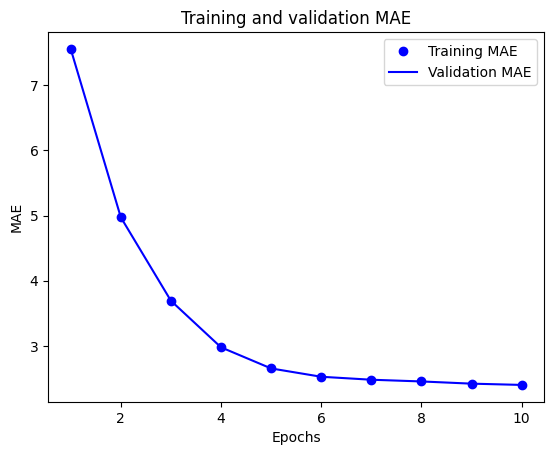

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


#LSTM - Droupout Regularization

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 154s 729ms/step - loss: 87.2080 - mae: 7.3753 - val_loss: 55.0431 - val_mae: 5.6715
Epoch 2/10
205/205 [==============================] - 153s 744ms/step - loss: 46.3870 - mae: 5.1390 - val_loss: 31.0872 - val_mae: 4.1320
Epoch 3/10
205/205 [==============================] - 155s 754ms/step - loss: 31.1077 - mae: 4.1886 - val_loss: 18.4561 - val_mae: 3.1826
Epoch 4/10
205/205 [==============================] - 153s 737ms/step - loss: 23.7306 - mae: 3.7015 - val_loss: 12.8879 - val_mae: 2.7171
Epoch 5/10
205/205 [==============================] - 150s 721ms/step - loss: 20.8829 - mae: 3.5004 - val_loss: 10.8942 - val_mae: 2.5464
Epoch 6/10
205/205 [==============================] - 146s 710ms/step - loss: 19.6415 - mae: 3.4030 - val_loss: 10.2321 - val_mae: 2.4836
Epoch 7/10
205/205 [==============================] - 152s 733ms/step - loss: 18.8010 - mae: 3.3338 - val_loss: 10.0157 - val_mae: 2.4660
Epoch 8/10
205/205 [==============

102/102 [==============================] - 20s 179ms/step - loss: 10.9122 - mae: 2.5794
Test MAE: 2.58


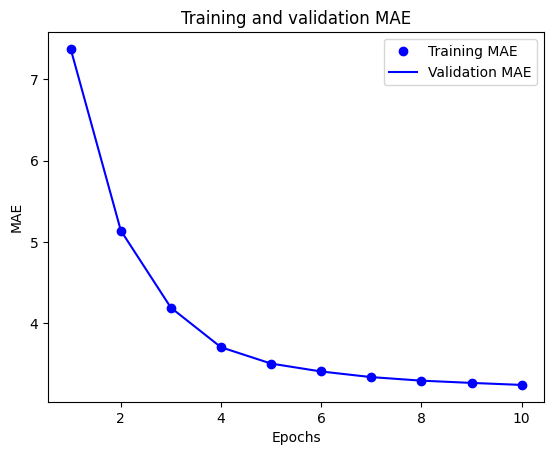

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#LSTM - Stacked setup with 16 units

In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
205/205 [==============================] - 55s 240ms/step - loss: 80.3320 - mae: 7.0092 - val_loss: 53.2698 - val_mae: 5.5571
Epoch 2/10
205/205 [==============================] - 47s 223ms/step - loss: 40.0402 - mae: 4.7290 - val_loss: 29.8833 - val_mae: 4.0145
Epoch 3/10
205/205 [==============================] - 54s 256ms/step - loss: 22.5596 - mae: 3.4950 - val_loss: 17.9445 - val_mae: 3.1238
Epoch 4/10
205/205 [==============================] - 49s 236ms/step - loss: 14.3859 - mae: 2.8480 - val_loss: 12.5796 - val_mae: 2.6900
Epoch 5/10
205/205 [==============================] - 53s 256ms/step - loss: 10.9289 - mae: 2.5460 - val_loss: 10.5087 - val_mae: 2.5039
Epoch 6/10
205/205 [==============================] - 53s 253ms/step - loss: 9.6283 - mae: 2.4142 - val_loss: 10.1949 - val_mae: 2.4744
Epoch 7/10
205/205 [==============================] - 48s 228ms/step - loss: 9.1310 - mae: 2.3543 - val_loss: 9.9462 - val_mae: 2.4592
Epoch 8/10
205/205 [========================

#LSTM- Stacked with 32 Units

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
205/205 [==============================] - 52s 228ms/step - loss: 46.5327 - mae: 5.0786 - val_loss: 22.2084 - val_mae: 3.5234
Epoch 2/10
205/205 [==============================] - 47s 226ms/step - loss: 15.1256 - mae: 2.9279 - val_loss: 11.8952 - val_mae: 2.6509
Epoch 3/10
205/205 [==============================] - 53s 253ms/step - loss: 10.0541 - mae: 2.4587 - val_loss: 10.2539 - val_mae: 2.4788
Epoch 4/10
205/205 [==============================] - 53s 250ms/step - loss: 8.8673 - mae: 2.3181 - val_loss: 10.3981 - val_mae: 2.5257
Epoch 5/10
205/205 [==============================] - 53s 254ms/step - loss: 8.3186 - mae: 2.2466 - val_loss: 10.2665 - val_mae: 2.5226
Epoch 6/10
205/205 [==============================] - 54s 256ms/step - loss: 7.7670 - mae: 2.1698 - val_loss: 10.3861 - val_mae: 2.5213
Epoch 7/10
205/205 [==============================] - 56s 268ms/step - loss: 7.3058 - mae: 2.1035 - val_loss: 11.1924 - val_mae: 2.6370
Epoch 8/10
205/205 [=========================

#LSTM - Stacked setup with 8 units

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
205/205 [==============================] - 53s 231ms/step - loss: 116.5204 - mae: 8.7642 - val_loss: 95.0688 - val_mae: 7.7425
Epoch 2/10
205/205 [==============================] - 54s 258ms/step - loss: 74.4601 - mae: 6.6987 - val_loss: 63.4511 - val_mae: 6.1277
Epoch 3/10
205/205 [==============================] - 53s 253ms/step - loss: 53.4849 - mae: 5.5437 - val_loss: 46.4403 - val_mae: 5.1214
Epoch 4/10
205/205 [==============================] - 53s 253ms/step - loss: 39.4217 - mae: 4.6783 - val_loss: 33.9440 - val_mae: 4.2922
Epoch 5/10
205/205 [==============================] - 54s 259ms/step - loss: 29.0905 - mae: 3.9761 - val_loss: 25.0743 - val_mae: 3.6531
Epoch 6/10
205/205 [==============================] - 53s 254ms/step - loss: 21.8696 - mae: 3.4470 - val_loss: 19.0321 - val_mae: 3.2024
Epoch 7/10
205/205 [==============================] - 49s 234ms/step - loss: 17.0642 - mae: 3.0783 - val_loss: 15.1288 - val_mae: 2.8963
Epoch 8/10
205/205 [====================

#LSTM - Stacked setup with 64 units

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 57s 258ms/step - loss: 24.8355 - mae: 3.6535 - val_loss: 10.7096 - val_mae: 2.5204
Epoch 2/10
205/205 [==============================] - 47s 224ms/step - loss: 9.3756 - mae: 2.3783 - val_loss: 10.1107 - val_mae: 2.4605
Epoch 3/10
205/205 [==============================] - 53s 250ms/step - loss: 6.9185 - mae: 2.0383 - val_loss: 11.0878 - val_mae: 2.6055
Epoch 4/10
205/205 [==============================] - 48s 228ms/step - loss: 5.2966 - mae: 1.7799 - val_loss: 11.8634 - val_mae: 2.7018
Epoch 5/10
205/205 [==============================] - 49s 237ms/step - loss: 4.2717 - mae: 1.5934 - val_loss: 12.5148 - val_mae: 2.7578
Epoch 6/10
205/205 [==============================] - 47s 226ms/step - loss: 3.5482 - mae: 1.4469 - val_loss: 12.9007 - val_mae: 2.7941
Epoch 7/10
205/205 [==============================] - 48s 227ms/step - loss: 3.1270 - mae: 1.3517 - val_loss: 13.0907 - val_mae: 2.8316
Epoch 8/10
205/205 [===========================

#LSTM - dropout-regularized, stacked model

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
205/205 [==============================] - 293s 1s/step - loss: 116.5308 - mae: 8.7244 - val_loss: 93.0583 - val_mae: 7.6621
Epoch 2/10
205/205 [==============================] - 265s 1s/step - loss: 80.3152 - mae: 6.9825 - val_loss: 69.0285 - val_mae: 6.4586
Epoch 3/10
205/205 [==============================] - 267s 1s/step - loss: 62.5883 - mae: 6.0290 - val_loss: 51.3997 - val_mae: 5.4521
Epoch 4/10
205/205 [==============================] - 267s 1s/step - loss: 49.2088 - mae: 5.2590 - val_loss: 38.0234 - val_mae: 4.6020
Epoch 5/10
205/205 [==============================] - 287s 1s/step - loss: 39.6878 - mae: 4.6826 - val_loss: 28.0526 - val_mae: 3.8926
Epoch 6/10
205/205 [==============================] - 265s 1s/step - loss: 33.0105 - mae: 4.2772 - val_loss: 20.9693 - val_mae: 3.3490
Epoch 7/10
205/205 [==============================] - 266s 1s/step - loss: 29.0108 - mae: 4.0268 - val_loss: 16.4045 - val_mae: 2.9803
Epoch 8/10
205/205 [==============================] - 

102/102 [==============================] - 24s 224ms/step - loss: 13.5812 - mae: 2.7810
Test MAE: 2.78


In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
205/205 [==============================] - 52s 227ms/step - loss: 102.6194 - mae: 8.0656 - val_loss: 90.6711 - val_mae: 7.5773
Epoch 2/10
205/205 [==============================] - 46s 221ms/step - loss: 72.1187 - mae: 6.5495 - val_loss: 64.5680 - val_mae: 6.2812
Epoch 3/10
205/205 [==============================] - 46s 221ms/step - loss: 50.4535 - mae: 5.3552 - val_loss: 46.0417 - val_mae: 5.2283
Epoch 4/10
205/205 [==============================] - 48s 232ms/step - loss: 35.0856 - mae: 4.4162 - val_loss: 34.5312 - val_mae: 4.5269
Epoch 5/10
205/205 [==============================] - 46s 221ms/step - loss: 25.2080 - mae: 3.7607 - val_loss: 27.1399 - val_mae: 4.0286
Epoch 6/10
205/205 [==============================] - 52s 247ms/step - loss: 19.6171 - mae: 3.3600 - val_loss: 25.4956 - val_mae: 4.0186
Epoch 7/10
205/205 [==============================] - 52s 248ms/step - loss: 17.0496 - mae: 3.1715 - val_loss: 22.6922 - val_mae: 3.7773
Epoch 8/10
205/205 [====================

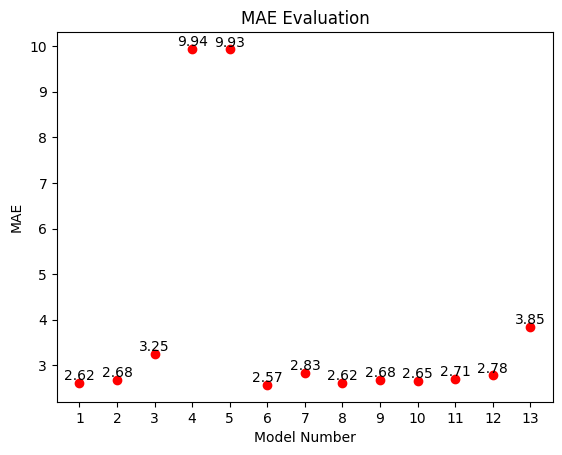

In [3]:
import matplotlib.pyplot as plt

Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13")
Mae = (2.62,2.68,3.25,9.94,9.93,2.57,2.83,2.62,2.68,2.65,2.71,2.78,3.85)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models, Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
